In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

url = 'https://www.census2011.co.in/literacy.php'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfs = pd.read_html(r.text)
#print(f'Total tables: {len(dfs)}')
df = dfs[0]

#print(df.columns)
df.drop(columns =['#'],inplace=True)
df.sort_values(['Male'], ascending=[False], inplace=True)
df.head(5)

,State,Literacy,Male,Female,% Change
1,Kerala,94.00,96.11,92.07,3.14
2,Lakshadweep,91.85,95.56,87.95,5.19
3,Mizoram,91.33,93.35,89.27,2.53
4,Goa,88.70,92.65,84.66,6.69
6,Daman and Diu,87.10,91.54,79.55,8.92


In [2]:
#Reference: https://colab.research.google.com/drive/1lKuaZUp8LggiDFbct0-DcUDMMYdvO4Tp?usp=sharing#scrollTo=sBkAKOCTYOek

def color_title(labels, colors, textprops = {'size':'large'}, ax = None, y = 1.013,
               precision = 10**-2):
     
    "Creates a centered title with multiple colors. Don't change axes limits afterwards."
        
    if ax == None:
        ax = plt.gca()
        
    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords
    
    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts
    
    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :         
        x_pos = shift 
        
        for label, col in zip(labels, colors):

            try:
                text[label].remove()
            except KeyError:
                pass
            
            text[label] = ax.text(x_pos, y, label, 
                        transform = transform, 
                        ha = 'left',
                        color = col,
                                            **textprops)
            
            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1
            
        xT = x_pos # where all text ends
        
        shift += precision/2 # increase for next iteration
      
        if x_pos > 1: # guardrail 
            break



In [3]:
def create_dumbell():
    # Create playground
    fig, ax = plt.subplots(figsize=(10, 8))

    # Visuals
    df.plot.scatter(x='Male',  y='State', ax=ax, color='#1E1E1E', s=60)
    df.plot.scatter(x='Female', y='State', ax=ax,c='#FC7D0B', s=60)
    ax.hlines(y= range(0,len(df.index)), xmin=df['Female'], xmax=df['Male'], linewidth=5, color='#BDBDBD', zorder=0)


    # Background and remove noise
    ax.set_facecolor('#F5F5F5')
    ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set(ylabel=None)
    ax.set(xlabel=None)

    # Title color
    label_list = ['% of Literacy ', 'Female', ' and ', 'Male ', 'Statewise']
    colors = ['#969FA7', '#FC7D0B', '#969FA7', '#1E1E1E', '#969FA7']
    color_title(label_list, colors)

    plt.text(50,-4,'Source: Census India 2011', c='#969FA7');
    #plt.show()

    plt.savefig('LiteracyIndiaStatewiseGender.png', dpi=300, facecolor='#F5F5F5',bbox_inches='tight' )

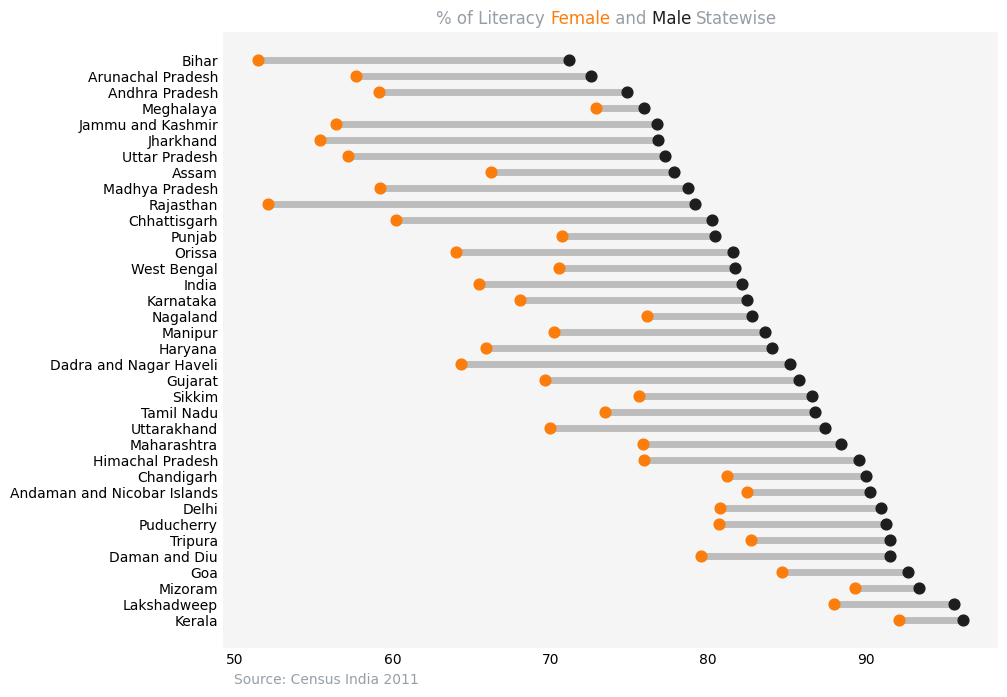

In [4]:
#Calling main function to create the dumbell plot
create_dumbell()